<a href="https://colab.research.google.com/github/EwoutH/Helsinki-flood-BEP-project/blob/road-graph/road-graph/OSMnx_road_graph_analysis_BEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook 2 of 2, first part: https://colab.research.google.com/drive/1DE6MA7E2gOwGp7m35fzvrv5HQgdS3UQT

### Installation

Note that OSMnx is installed from my [own branch](https://github.com/EwoutH/osmnx/tree/edge-sum-refactor-2) with slight modification to the `travel_time` calculation. See [gboeing/osmnx#721](https://github.com/gboeing/osmnx/pull/721).

In [4]:
pip install -e git+https://github.com/EwoutH/osmnx.git@edge-sum-refactor-2#egg=OSMnx

Obtaining OSMnx from git+https://github.com/EwoutH/osmnx.git@edge-sum-refactor-2#egg=OSMnx
  Updating ./src/osmnx clone (to revision edge-sum-refactor-2)
  Running command git fetch -q --tags
  Running command git reset --hard -q b519b4bb178dce35c9197d227997e912b3ed401e
  Found existing installation: osmnx 1.1.1
    Uninstalling osmnx-1.1.1:
      Successfully uninstalled osmnx-1.1.1
  Running setup.py develop for OSMnx


In [5]:
pip install ./src/osmnx

Processing ./src/osmnx
  Created wheel for osmnx: filename=osmnx-1.1.1-cp37-none-any.whl size=93657 sha256=1e27e69818947f688ae7b21745d7c3b37a3c6fc799a19a77c7e739906e2a45a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-60m5aexn/wheels/43/a0/b3/5627d0ffe743765b2a32057b8ce416e7bc03a7e0f8560005b3
Successfully built osmnx
  Found existing installation: osmnx 1.1.1
    Can't uninstall 'osmnx'. No files were found to uninstall.


In [6]:
# Import packages
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
#import igraph as ig
import random

# Print versions
print(f'NetworkX version {nx.__version__}')
print(f'GeoPandas version {gpd.__version__}')
print(f'Pandas version {pd.__version__}')
print(f'NumPy version {np.__version__}')
print(f'OSMnx version {ox.__version__}')
#print(f'igraph version {ig.__version__}')

NetworkX version 2.5.1
GeoPandas version 0.9.0
Pandas version 1.1.5
NumPy version 1.19.5
OSMnx version 1.1.1


### Graph
The following files are required:
* `road-graph-def.graphml`
* `TomTom-data-ext.csv`
* `TomTom-data-int.csv`
* `node-regions.csv`

In [7]:
# Load the MultiDiGraph and convert to DiGraph
ntypes = {'street_count': int, 'lon': float, 'lat': float, 'betw_cent': float}
etypes = {'min_lanes': int, 'oneway': bool, 'length': float, 'free_flow_speed': float,
          'free_flow_time': float, 'free_flow_capacity': int, 'edge_betw_cent': float}

G2b = ox.io.load_graphml('road-graph-def.graphml',edge_dtypes=etypes)
G2a = ox.utils_graph.get_digraph(G2b,weight='free_flow_time')

In [8]:
# Confirm network types
print(type(G2b))
print(type(G2a))

<class 'networkx.classes.multidigraph.MultiDiGraph'>
<class 'networkx.classes.digraph.DiGraph'>


In [9]:
# Load nodes and edges as GeoPandas Dataframes to be able to observe and plot them
nodes, edges = ox.graph_to_gdfs(G2b, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

In [10]:
nodes["x"][5]

25498076.17910094

### Index and assign OD regions

In [11]:
# Some code to link each point to a region
type(G2a)
noderegions = pd.read_csv('noderegions.csv', index_col=[0], skipinitialspace=True)
noderegions

,region,nodes,osmids,count
id,,,,
1,1,1254,2044,12
2,1,1373,784,12
3,1,1374,785,12
4,1,1375,1325,12
5,1,1376,1060,12
...,...,...,...,...
2583,199,1589,927,12
2584,199,1602,1896,12
2585,199,1719,1055,12


In [12]:
# Prepare the dataframe to be converted to a dictionary
noderegions2 = noderegions.set_index('osmids')
noderegions2 = noderegions2.drop(columns=['nodes', 'count'])
noderegions2.loc[noderegions2['region'] == 144]
#nx.set_node_attributes(G2a, node_cent, "region")

,region
osmids,
0,144
140,144
1,144
142,144
112,144
113,144
1753,144
114,144
134,144


In [13]:
# Convert the Pandas dataframe to a dict
region_dict = noderegions2.to_dict('dict')['region']
print(region_dict)

{2044: 1, 784: 1, 785: 1, 1325: 1, 1060: 1, 786: 1, 1721: 1, 2100: 1, 2218: 1, 916: 1, 2045: 1, 935: 1, 484: 2, 485: 2, 954: 2, 920: 2, 921: 2, 1321: 2, 950: 2, 951: 2, 952: 2, 953: 2, 955: 2, 956: 2, 1485: 2, 1006: 3, 1007: 3, 1008: 3, 1010: 3, 1009: 3, 1011: 3, 1012: 3, 1030: 3, 1013: 3, 1014: 3, 1483: 3, 1029: 3, 1031: 3, 947: 4, 948: 4, 949: 4, 1001: 4, 998: 4, 999: 4, 1000: 4, 1002: 4, 1003: 4, 1924: 4, 1004: 4, 1005: 4, 793: 5, 342: 5, 735: 5, 1661: 5, 1654: 5, 346: 5, 782: 5, 883: 5, 842: 5, 733: 5, 734: 5, 1586: 5, 992: 6, 944: 6, 825: 6, 996: 6, 946: 6, 995: 6, 943: 6, 1834: 6, 990: 6, 991: 6, 993: 6, 997: 6, 341: 7, 1019: 7, 343: 7, 344: 7, 737: 7, 345: 7, 1662: 7, 736: 7, 739: 7, 738: 7, 2226: 7, 994: 7, 51: 8, 1282: 8, 1043: 8, 52: 8, 71: 8, 70: 8, 1016: 8, 867: 8, 1015: 8, 1042: 8, 1017: 8, 1018: 8, 49: 9, 1040: 9, 67: 9, 727: 9, 1039: 9, 90: 9, 709: 9, 717: 9, 718: 9, 1037: 9, 1038: 9, 1630: 9, 6: 10, 7: 10, 2482: 10, 46: 10, 1786: 10, 1025: 10, 779: 10, 2445: 10, 1024: 1

In [14]:
# Add region as a node attribute
nx.set_node_attributes(G2a, region_dict, 'region')
assert G2a.nodes[0]['region'] == 144

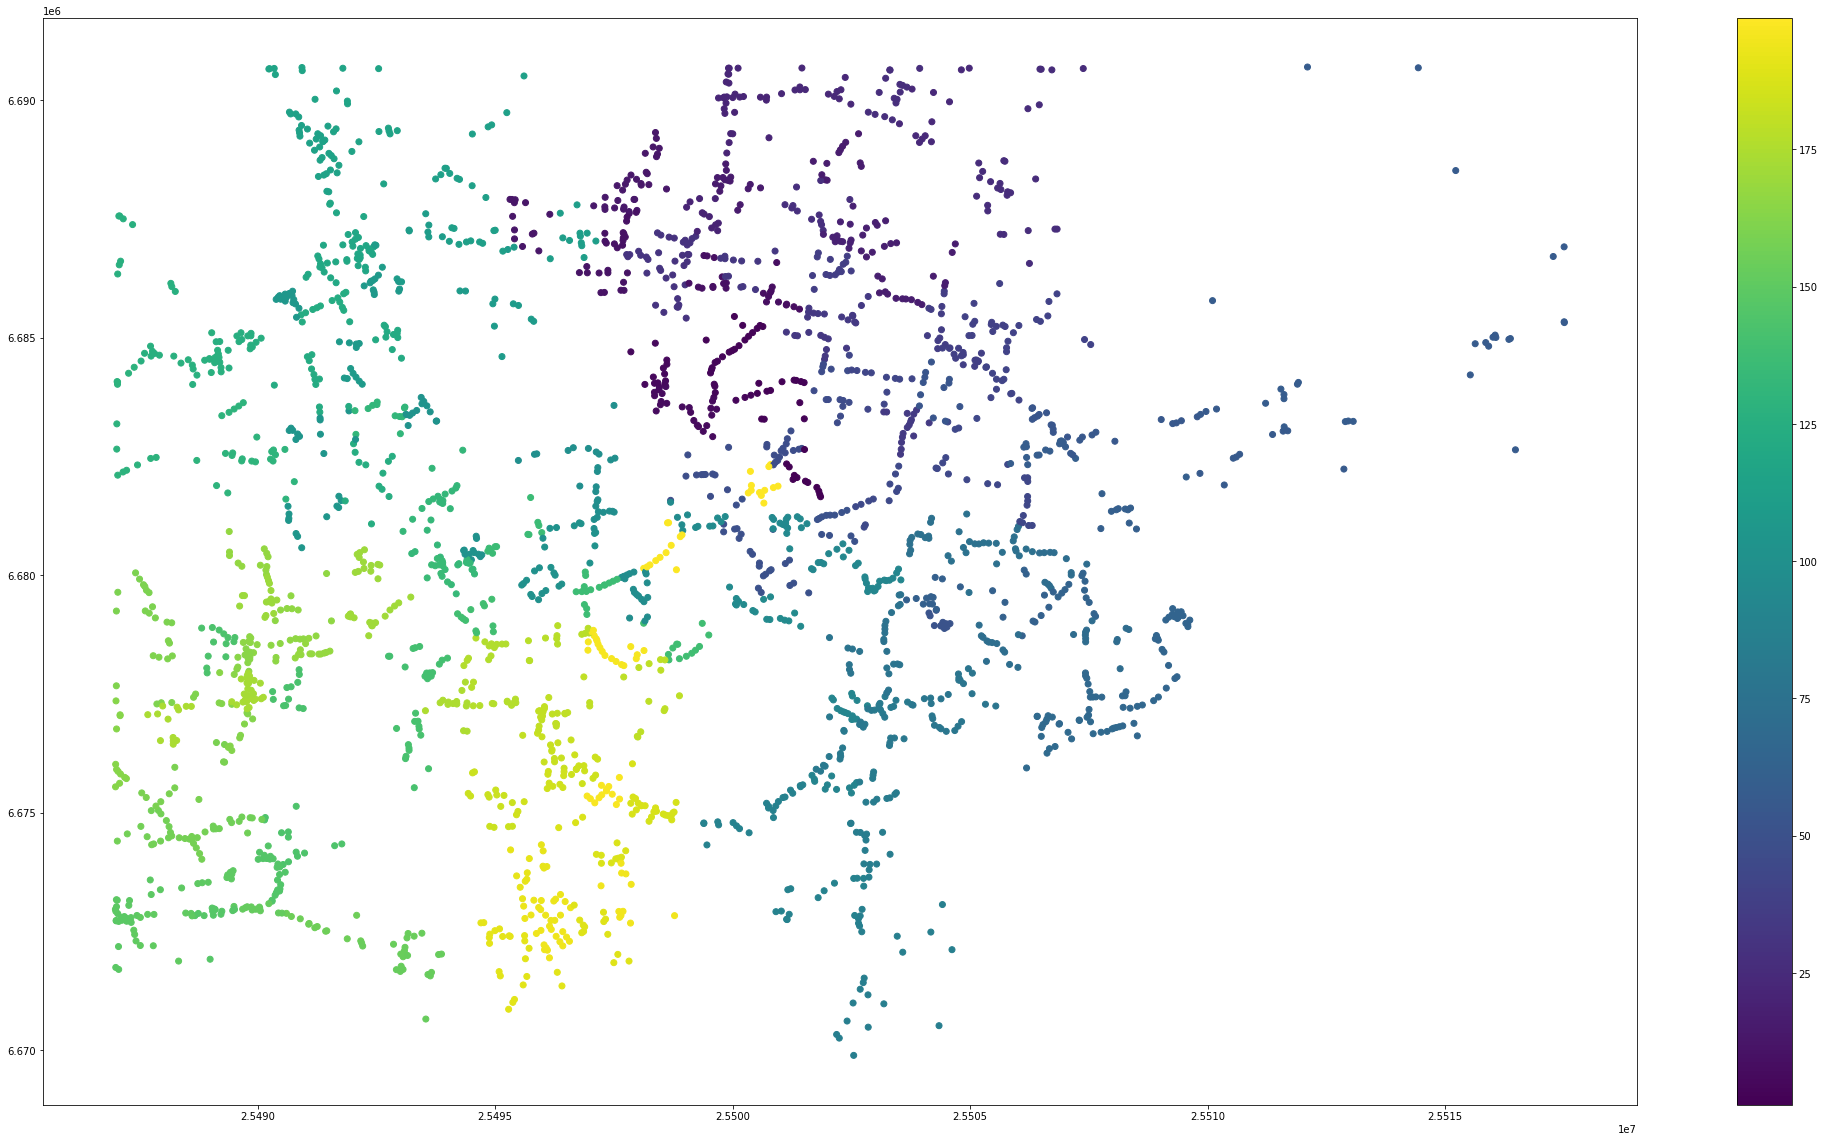

In [15]:
# Graph!
nodes2 = ox.graph_to_gdfs(G2a, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)
ax = nodes2.plot(column='region', figsize=(36,20), legend=True)

In [16]:
# Now the same steps for the count
nodecounts = noderegions.set_index('osmids')
nodecounts = nodecounts.drop(columns=['nodes', 'region'])

In [17]:
# Convert the Pandas dataframe to a dict
count_dict = nodecounts.to_dict('dict')['count']
print(count_dict)

{2044: 12, 784: 12, 785: 12, 1325: 12, 1060: 12, 786: 12, 1721: 12, 2100: 12, 2218: 12, 916: 12, 2045: 12, 935: 12, 484: 13, 485: 13, 954: 13, 920: 13, 921: 13, 1321: 13, 950: 13, 951: 13, 952: 13, 953: 13, 955: 13, 956: 13, 1485: 13, 1006: 13, 1007: 13, 1008: 13, 1010: 13, 1009: 13, 1011: 13, 1012: 13, 1030: 13, 1013: 13, 1014: 13, 1483: 13, 1029: 13, 1031: 13, 947: 12, 948: 12, 949: 12, 1001: 12, 998: 12, 999: 12, 1000: 12, 1002: 12, 1003: 12, 1924: 12, 1004: 12, 1005: 12, 793: 12, 342: 12, 735: 12, 1661: 12, 1654: 12, 346: 12, 782: 12, 883: 12, 842: 12, 733: 12, 734: 12, 1586: 12, 992: 12, 944: 12, 825: 12, 996: 12, 946: 12, 995: 12, 943: 12, 1834: 12, 990: 12, 991: 12, 993: 12, 997: 12, 341: 12, 1019: 12, 343: 12, 344: 12, 737: 12, 345: 12, 1662: 12, 736: 12, 739: 12, 738: 12, 2226: 12, 994: 12, 51: 12, 1282: 12, 1043: 12, 52: 12, 71: 12, 70: 12, 1016: 12, 867: 12, 1015: 12, 1042: 12, 1017: 12, 1018: 12, 49: 12, 1040: 12, 67: 12, 727: 12, 1039: 12, 90: 12, 709: 12, 717: 12, 718: 12

In [18]:
# Add count as a node attribute
nx.set_node_attributes(G2a, count_dict, 'count')
assert G2a.nodes[0]['count'] == 13

In [19]:
regioncounts = noderegions.set_index('region')
regioncounts = regioncounts.drop(columns=['nodes', 'osmids'])
region_counts = regioncounts.to_dict('dict')['count']
print(region_counts)
assert region_counts[144] == 13

{1: 12, 2: 13, 3: 13, 4: 12, 5: 12, 6: 12, 7: 12, 8: 12, 9: 12, 10: 15, 11: 12, 12: 13, 13: 15, 14: 16, 15: 16, 16: 12, 17: 15, 18: 12, 19: 13, 20: 12, 21: 12, 22: 15, 23: 13, 24: 12, 25: 12, 26: 16, 27: 16, 28: 12, 29: 14, 30: 12, 31: 12, 32: 12, 33: 13, 34: 12, 35: 16, 36: 12, 37: 15, 38: 16, 39: 13, 40: 12, 41: 12, 42: 12, 43: 12, 44: 12, 45: 12, 46: 14, 47: 16, 48: 12, 49: 12, 50: 12, 51: 12, 52: 12, 53: 12, 54: 12, 55: 12, 56: 12, 57: 16, 58: 12, 59: 16, 60: 12, 61: 12, 62: 12, 63: 12, 64: 13, 65: 12, 66: 12, 67: 12, 68: 12, 69: 15, 70: 12, 71: 12, 72: 13, 73: 12, 74: 12, 75: 12, 76: 12, 77: 14, 78: 12, 79: 13, 80: 12, 81: 12, 82: 12, 83: 12, 84: 12, 85: 12, 86: 12, 87: 12, 88: 14, 89: 12, 90: 12, 91: 15, 92: 16, 93: 13, 94: 16, 95: 17, 96: 12, 97: 19, 98: 14, 99: 13, 100: 14, 101: 12, 102: 12, 103: 13, 104: 12, 105: 12, 106: 16, 107: 12, 108: 12, 109: 12, 110: 12, 111: 12, 112: 12, 113: 13, 114: 17, 115: 13, 116: 12, 117: 12, 118: 16, 119: 12, 120: 13, 121: 12, 122: 12, 123: 13, 

In [21]:
# Benchmarks
import timeit

print(timeit.timeit(lambda: G2a.nodes[5]['region'], number=10000))
print(timeit.timeit(lambda: region_dict[5], number=10000))

print(timeit.timeit(lambda: G2a.nodes[0]['count'], number=10000))
print(timeit.timeit(lambda: region_counts[144], number=10000))

0.01501617800022359
0.0011298919998807833
0.008373825001399382
0.0010391630003141472


### OD data

In [22]:
# Import of TomTom OD data as MultiIndexed 
tte = pd.read_csv('TomTom-data-ext.csv', index_col=[0,1], skipinitialspace=True)
tti = pd.read_csv('TomTom-data-int.csv', index_col=[0,1], skipinitialspace=True)

In [23]:
tte

All  Night  Day  Evening
Origin Destination                          
1      1            116      1  109       13
       2             54      2   38        0
       3              4      1    4        0
       4             13      0   11        2
       5             15      0   13        0
...                 ...    ...  ...      ...
199    195           47      2   32        1
       196           64      1   45        0
       197           71     10   51        0
       198           96      4   70        0
       199          431     50  313       44

[39601 rows x 4 columns]

In [24]:
# Print some validation
print(tte.loc[(1, 1), "All"])
print(tte.at[(1, 1), "All"])
print(tte._get_value(0, 0, "All"))

# Small benchmark
print(timeit.timeit(lambda: tte.loc[(1, 1), "All"], number=10000))
print(timeit.timeit(lambda: tte.at[(1, 1), "All"], number=10000))
print(timeit.timeit(lambda: tte._get_value(1-1, 1-1, "All"), number=10000))

116
116
116
2.2412148370003706
0.17001568100022268
0.19104101800076023


### Calculate paths

In [25]:
# Calculate all the shortests paths between nodes with Dijkstra's algorithm
paths = dict(nx.all_pairs_dijkstra_path(G2a, cutoff=None, weight="free_flow_time"))

In [26]:
# Print two paths. Note the differences due to directionality of the graph.
print(paths[0][4])
print(paths[4][0][::-1])

[0, 140, 2470, 2469, 2472, 1766, 117, 2479, 2481, 121, 1455, 122, 123, 124, 2029, 1850, 2030, 220, 125, 1413, 126, 127, 128, 129, 1459, 1464, 1463, 130, 1794, 131, 1742, 841, 21, 20, 341, 793, 1635, 1734, 724, 48, 44, 1631, 2417, 6, 7, 2179, 5, 1026, 3, 4]
[0, 140, 2471, 2467, 2468, 2571, 136, 117, 135, 2480, 137, 2149, 2018, 2285, 138, 139, 1851, 1762, 1977, 18, 585, 17, 540, 1409, 214, 213, 211, 207, 210, 1465, 206, 218, 2251, 589, 1444, 1438, 1537, 1662, 842, 732, 1711, 728, 47, 45, 843, 2418, 1710, 1709, 2178, 1708, 94, 10, 2127, 844, 4]


In [27]:
# Calculate and print the average path length in the whole graph
avg_path_length = nx.average_shortest_path_length(G2a, weight="free_flow_time")
print(avg_path_length)

732.85901899163


In [28]:
# Calculate all the path lengths
path_lengths = dict(nx.all_pairs_dijkstra_path_length(G2a, weight="free_flow_time"))
print(path_lengths[0][4])
print(path_lengths[4][0])

1181.6169070237052
1253.4311309639209


In [29]:
print(list(path_lengths.items())[:1])

[(0, {0: 0, 140: 12.492803626271119, 134: 19.188061699191323, 2470: 38.62479839266539, 2467: 45.80046089024325, 114: 45.914537342746286, 1: 46.813176, 2469: 47.22479839266539, 2468: 53.629585254412206, 113: 57.33599137362407, 142: 57.981024, 1752: 59.64720819291462, 2472: 60.52479839266539, 2471: 62.100117388420834, 143: 64.06325004503006, 1766: 67.9247983926654, 133: 68.02303090118134, 2465: 70.05830289534323, 2444: 74.91502402943932, 2473: 90.02421287792431, 132: 96.31502402943931, 2546: 97.22421287792432, 2057: 98.69312072067581, 1730: 102.02696289534322, 832: 106.46703287792431, 2464: 110.38696953685934, 112: 113.63823028235683, 1965: 115.72696289534322, 117: 118.6413609840836, 162: 123.72696289534322, 116: 126.9413609840836, 163: 127.62696289534323, 159: 129.32696289534323, 2560: 137.11688148941906, 483: 137.8413609840836, 906: 140.42696289534322, 2236: 143.1413609840836, 157: 144.42696289534325, 905: 145.4097489084615, 482: 146.8084827081547, 118: 148.51929569623388, 2559: 149.76

### Weighted routes

In [59]:
# Create empty variables
traveltime = {}
ttweighted = {}
tripcount = 0

# Calculation of path weight
for origin,d in path_lengths.items():
  ro = region_dict[origin]
  for destination, length in d.items():
    rd = region_dict[destination]
    trips = tte.at[(ro, rd), "All"]
    weight = trips / (region_counts[ro]*region_counts[rd])
    traveltime[(origin,destination)] = length
    ttweighted[(origin,destination)] = length * weight


In [60]:
# Some manual validation
print('calculated:',ttweighted[(0,1)])
print('length:',path_lengths[0][1])
print('counts:',G2a.nodes[0]['count'],G2a.nodes[1]['count'])
print('trips:',tte.loc[(region_dict[0], region_dict[1]), "All"])
print('weighted:',path_lengths[0][1]*tte.loc[(ro, rd), "All"]/(G2a.nodes[0]['count']*G2a.nodes[1]['count']))

calculated: 323.2602153372781
length: 46.813176
counts: 13 13
trips: 1167
weighted: 603.0312671715976


In [61]:
# Calculate some stats
tripcount = tte.sum().sum()
totaltraveltime = sum(ttweighted.values())
meantraveltime = totaltraveltime / tripcount
routecount = len(ttweighted)

print(f'{tripcount} trips on {routecount} routes took {totaltraveltime} seconds, {meantraveltime} s on average')

3795559 trips on 6505175 routes took 939408812.6671828 seconds, 247.50209723183931 s on average


In [62]:
import statistics as s

ttwv = list(ttweighted.values())
print(f'Mean: {s.mean(ttwv)}\nMedian: {s.median(ttwv)}\n')
# Python 3.8+ add: Quantiles: {s.quantiles(ttwv, n=11, method="inclusive")}

Mean: 144.40946057058025
Median: 47.91296686142246



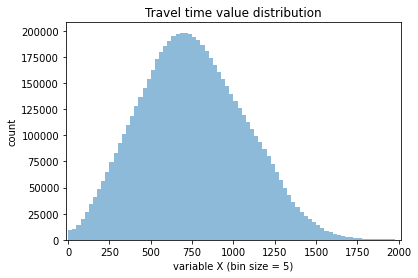

In [64]:
# Plot the regular travel time
ttv = traveltime.values()

from matplotlib import pyplot as plt

bins = np.arange(0, 2000, 25)
plt.xlim([-12.5, 2012.5])

plt.hist(ttv, bins=bins, alpha=0.5)
plt.title('Travel time value distribution')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()